In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np

In [2]:
tunable_data = []
fixed_data = []
for file_name in range(0, 10):
    # check if file exists
    try:
        tmp_df = pd.read_csv(f"pareto/tunable/{file_name}.csv")
        tunable_data.append(tmp_df)
        tmp_df = pd.read_csv(f"pareto/fixed/{file_name}.csv")
        fixed_data.append(tmp_df)
    except:
        continue

In [3]:
def prepare_data(data_list):
    custom_metrics = []
    for df in data_list:
        custom_metric = list(df["Custom_metric"])[::-1][0:100]

        current_max = 0
        new_custom_metric = []
        for value in custom_metric:
            if value >= current_max:
                current_max = value
            new_custom_metric.append(current_max)

        custom_metrics.append(new_custom_metric)
    return custom_metrics

def create_avg_dataset(new_list):
    # compute the mean and the std of the data in new_list 
    # and create a new dataset with these values
    mean = np.mean(new_list, axis=0)
    std = np.std(new_list, axis=0)

    df = pd.DataFrame()
    new_mean = []
    current_max = 0
    for value in mean:
        if value > current_max:
            current_max = value
            new_mean.append(current_max)
        else:
            new_mean.append(None)
    df["mean"] = mean
    df["dots"] = new_mean
    df["std"] = std
    df["index"] = list(range(0, 100))
    return df

In [4]:
new_list_tunable = prepare_data(tunable_data)
mean_df_tunable = create_avg_dataset(new_list_tunable)

In [5]:
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

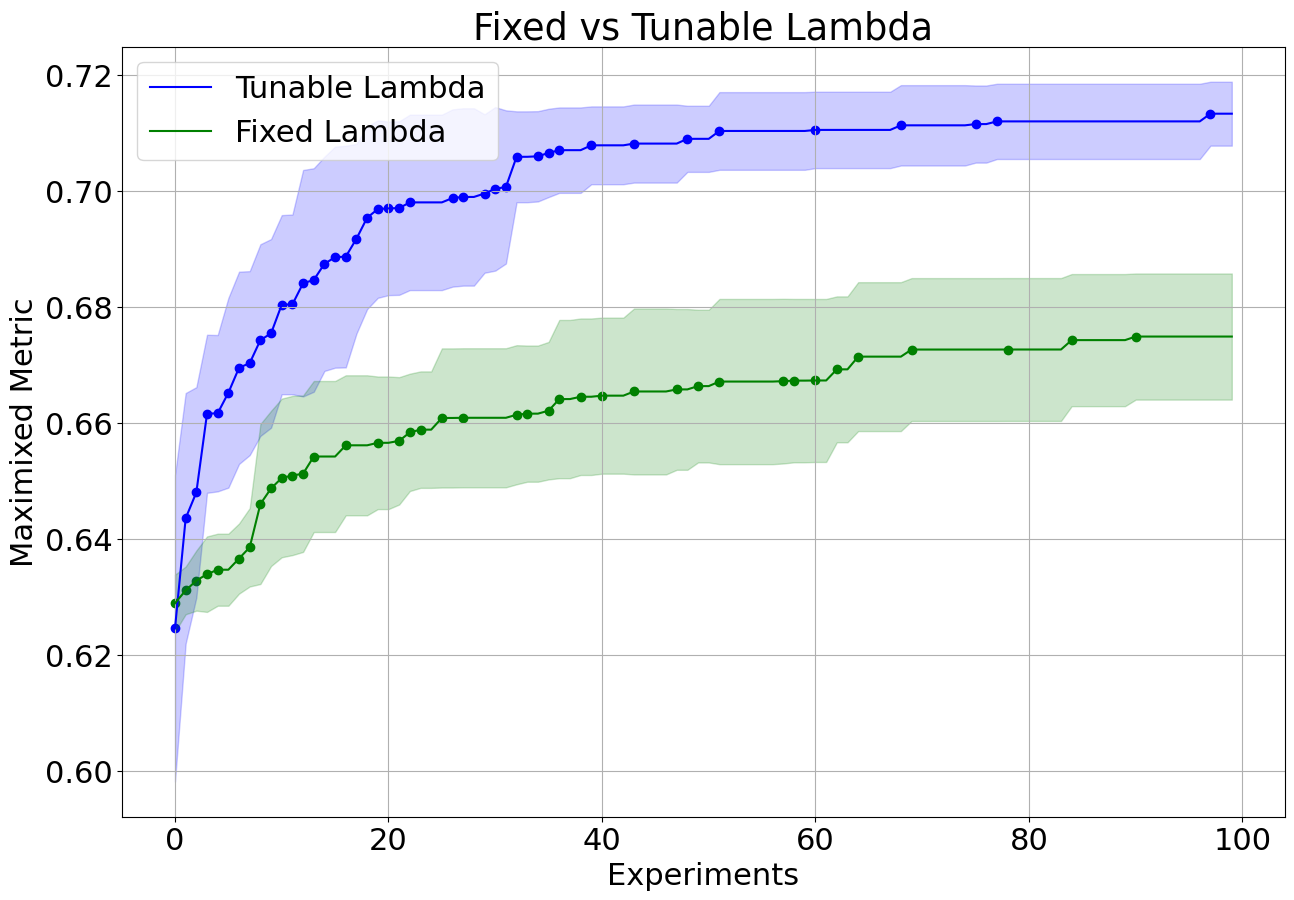

In [32]:
# Assuming mean_df is your DataFrame
plt.figure(figsize=(15, 10))

# Plot mean as a line
plt.plot(mean_df_tunable["index"], mean_df_tunable["mean"], label="Tunable Lambda", color="blue")
plt.plot(mean_df_fixed["index"], mean_df_fixed["mean"], label="Fixed Lambda", color="green")

# Plot dots for non-None values in "dots" column
dots_mask = mean_df_tunable["dots"].notnull()
plt.scatter(mean_df_tunable["index"][dots_mask], mean_df_tunable["dots"][dots_mask], color="blue", marker='o')

dots_mask = mean_df_fixed["dots"].notnull()
plt.scatter(mean_df_fixed["index"][dots_mask], mean_df_fixed["dots"][dots_mask], color="green", marker='o')


# Plot std as shaded area
plt.fill_between(mean_df_tunable["index"], mean_df_tunable["mean"] - mean_df_tunable["std"], mean_df_tunable["mean"] + mean_df_tunable["std"], alpha=0.2, color="blue")

plt.fill_between(mean_df_fixed["index"], mean_df_fixed["mean"] - mean_df_fixed["std"], mean_df_fixed["mean"] + mean_df_fixed["std"], alpha=0.2, color="green")

# Customize the plot
plt.title("Fixed vs Tunable Lambda")
plt.xlabel("Experiments")
plt.ylabel("Maximixed Metric")
plt.rcParams.update({'font.size': 22})

plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [7]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/lehabduh", 
    "/lucacorbucci/FL_PUF_Sweep/runs/7utw6mm7", 
    "/lucacorbucci/FL_PUF_Sweep/runs/548vh0es", 
    "/lucacorbucci/FL_PUF_Sweep/runs/8mdd0hig", 
    "/lucacorbucci/FL_PUF_Sweep/runs/idfgugyy", 
    "/lucacorbucci/FL_PUF_Sweep/runs/ss13yriw", 
    "/lucacorbucci/FL_PUF_Sweep/runs/fmdkrqj2", 
    "/lucacorbucci/FL_PUF_Sweep/runs/qwyio8lx", 
    "/lucacorbucci/FL_PUF_Sweep/runs/0m9peen0", 
    "/lucacorbucci/FL_PUF_Sweep/runs/v03nkl68", 
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/cvcugpdo", 
    "/lucacorbucci/FL_PUF_Sweep/runs/e7xd4bjm", 
    "/lucacorbucci/FL_PUF_Sweep/runs/pzv93sap", 
    "/lucacorbucci/FL_PUF_Sweep/runs/vgmdj7f8", 
    "/lucacorbucci/FL_PUF_Sweep/runs/na91e8ks", 
    "/lucacorbucci/FL_PUF_Sweep/runs/q69wmamr", 
    "/lucacorbucci/FL_PUF_Sweep/runs/twz794i1", 
    "/lucacorbucci/FL_PUF_Sweep/runs/l1fwor6n", 
    # "/lucacorbucci/FL_PUF_Sweep/runs/", 
    # "/lucacorbucci/FL_PUF_Sweep/runs/",
]

In [8]:
def get_df(api_link):
    api = wandb.Api()
    run = api.run(api_link)
    df = pd.DataFrame(run.scan_history())
    return df

def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df


In [9]:
tunable_experiments = []
for link in tunable_links:
    tunable_experiments.append(get_df(link))


In [10]:
fixed_experiments = []
for link in fixed_links:
    fixed_experiments.append(get_df(link))

In [11]:
tunable_train_accuracy = []
tunable_train_disparity = []
for experiment in tunable_experiments:
    experiment = remove_nan(
        ["Train Accuracy", "Training Disparity with statistics"], experiment
    )
    tunable_train_accuracy.append(list(experiment["Train Accuracy"])[0:40])
    tunable_train_disparity.append(list(experiment["Training Disparity with statistics"])[0:40])

fixed_train_accuracy = []
fixed_train_disparity = []
for experiment in fixed_experiments:
    experiment = remove_nan(
        ["Train Accuracy", "Training Disparity with statistics"], experiment
    )
    fixed_train_accuracy.append(list(experiment["Train Accuracy"])[0:40])
    fixed_train_disparity.append(list(experiment["Training Disparity with statistics"])[0:40])

fixed_mean_train_accuracy = np.mean(fixed_train_accuracy, axis=0)
fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
fixed_std_train_accuracy = np.std(fixed_train_accuracy, axis=0)
fixed_std_train_disparity = np.std(fixed_train_disparity, axis=0)

tunable_mean_train_accuracy = np.mean(tunable_train_accuracy, axis=0)
tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
tunable_std_train_accuracy = np.std(tunable_train_accuracy, axis=0)
tunable_std_train_disparity = np.std(tunable_train_disparity, axis=0)

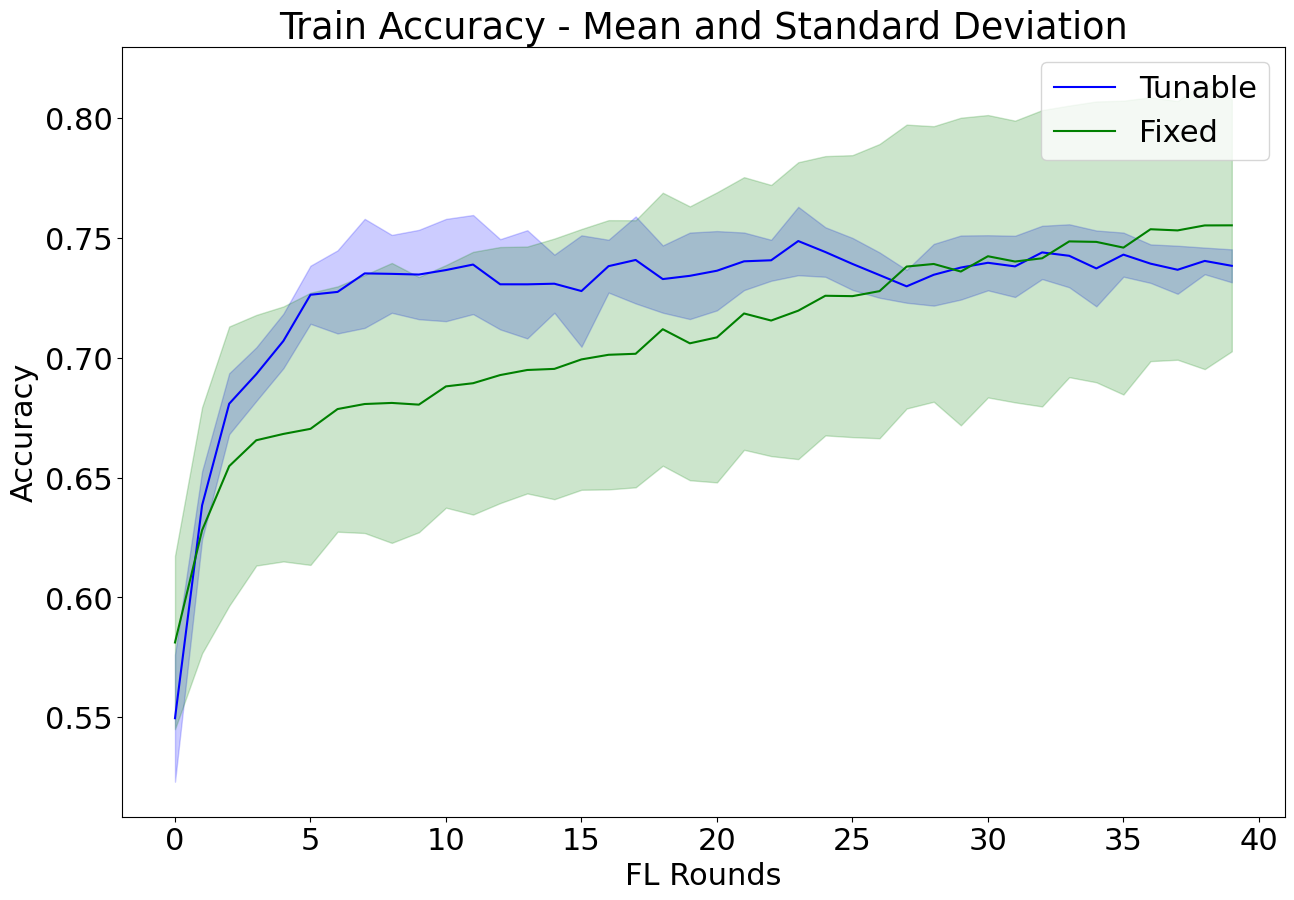

In [33]:
# plot train accuracy with fixed and tunable lambda and std
# Plotting the mean values over time
plt.figure(figsize=(15, 10))

x = list(range(0,40))
plt.plot(x, tunable_mean_train_accuracy, label='Tunable', color='blue')
plt.plot(x, fixed_mean_train_accuracy, label='Fixed', color='green')

# Plotting the standard deviation as an area around the mean
plt.fill_between(x, tunable_mean_train_accuracy - tunable_std_train_accuracy, tunable_mean_train_accuracy + tunable_std_train_accuracy, alpha=0.2, color='blue')
plt.fill_between(x, fixed_mean_train_accuracy - fixed_std_train_accuracy, fixed_mean_train_accuracy + fixed_std_train_accuracy, alpha=0.2, color='green')

# Adding labels and title
plt.xlabel('FL Rounds')
plt.rcParams.update({'font.size': 22})

plt.ylabel('Accuracy')
plt.title('Train Accuracy - Mean and Standard Deviation')
plt.legend()

# Show the plot
plt.show()

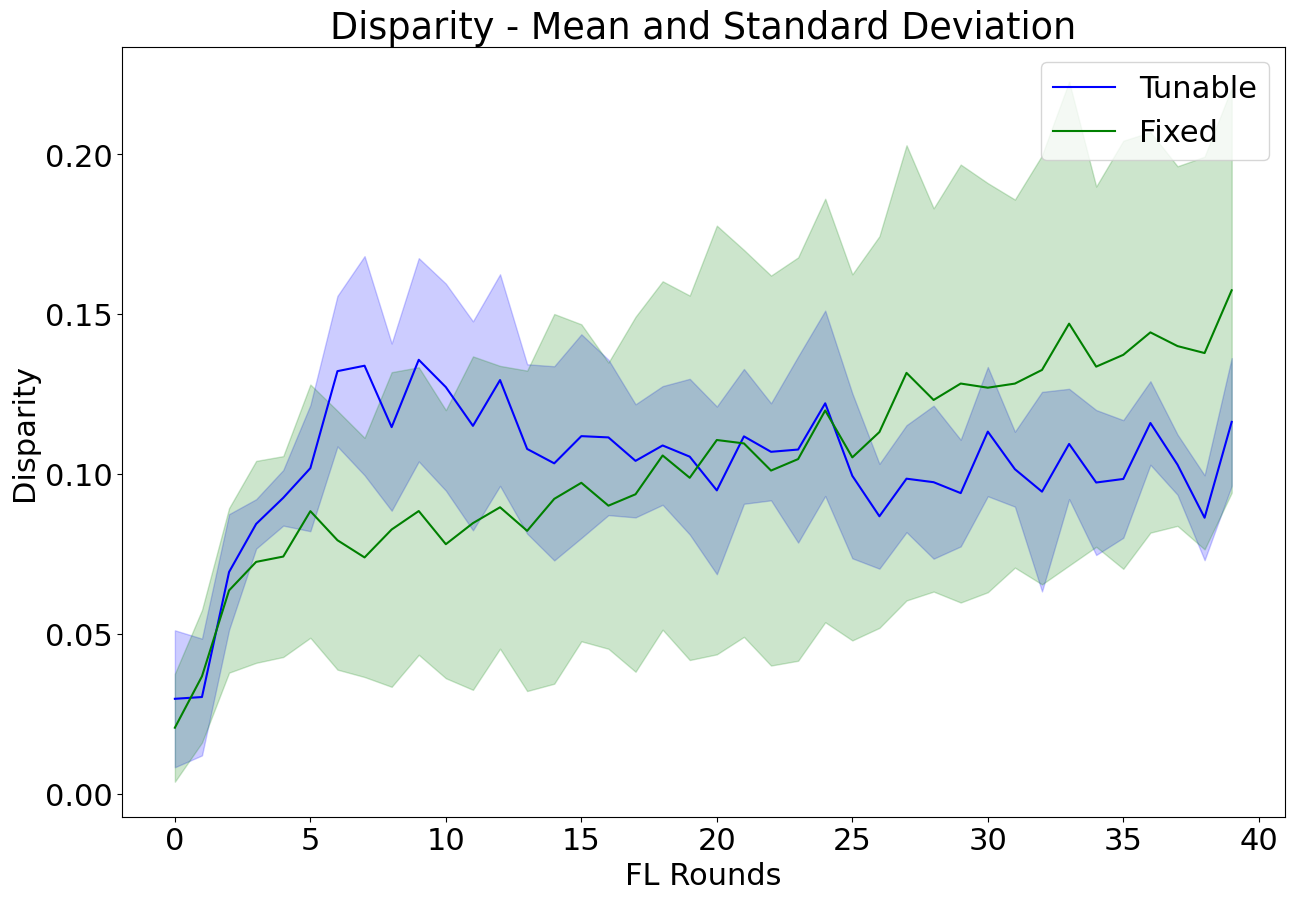

In [34]:
# plot train accuracy with fixed and tunable lambda and std
# Plotting the mean values over time
plt.figure(figsize=(15, 10))

x = list(range(0,40))
plt.plot(x, tunable_mean_train_disparity, label='Tunable', color='blue')
plt.plot(x, fixed_mean_train_disparity, label='Fixed', color='green')

# Plotting the standard deviation as an area around the mean
plt.fill_between(x, tunable_mean_train_disparity - tunable_std_train_disparity, tunable_mean_train_disparity + tunable_std_train_disparity, alpha=0.2, color='blue')
plt.fill_between(x, fixed_mean_train_disparity - fixed_std_train_disparity, fixed_mean_train_disparity + fixed_std_train_disparity, alpha=0.2, color='green')

# Adding labels and title
plt.xlabel('FL Rounds')
plt.rcParams.update({'font.size': 22})

plt.ylabel('Disparity')
plt.title('Disparity - Mean and Standard Deviation')
plt.legend()

# Show the plot
plt.show()